In [1]:

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms




# Our libraries
from train import train_model
from model_utils import *
from predict_utils import *
from vis_utils import *
from apmeter import *
from train_valid_split import *

# some initial setup
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)

In [2]:
use_gpu = True
cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if (cuda_available and use_gpu) else "cpu")

In [3]:
def plot_loss(trn_hist, val_hist, loss_acc):
    plt.plot(trn_hist, label='Training ' + loss_acc)
    plt.plot(val_hist, label='Validation ' + loss_acc)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel(loss_acc)
    plt.show()

In [ ]:
def freeze_bn(m):
    if isinstance(m, nn.BatchNorm2d):
        m.eval()

In [63]:
DATA_DIR = "F:/MyArticel/DTASET/NEW DATASETTT/willow_orgin_20_from_test/im2flow"
sz = 224
batch_size = 16

In [14]:
os.listdir(DATA_DIR)

['test', 'train', 'valid']

In [64]:
trn_dir = f'{DATA_DIR}train'
val_dir = f'{DATA_DIR}valid'

In [16]:
os.listdir(trn_dir)

['InteractingWithComputer',
 'Photographing',
 'PlayingMusic',
 'RidingBike',
 'RidingHorse',
 'Running',
 'Walking']

In [17]:
trn_fnames = glob.glob(f'{trn_dir}/*/*.png')
trn_fnames[:5]

['F:/MyArticel/DTASET/willow_orgin_20_from_test/im2flow/train\\InteractingWithComputer\\action0002.png',
 'F:/MyArticel/DTASET/willow_orgin_20_from_test/im2flow/train\\InteractingWithComputer\\action0004.png',
 'F:/MyArticel/DTASET/willow_orgin_20_from_test/im2flow/train\\InteractingWithComputer\\action0005.png',
 'F:/MyArticel/DTASET/willow_orgin_20_from_test/im2flow/train\\InteractingWithComputer\\action0006.png',
 'F:/MyArticel/DTASET/willow_orgin_20_from_test/im2flow/train\\InteractingWithComputer\\action0007.png']

In [18]:
# LOAD DATA
train_ds = datasets.ImageFolder(trn_dir)

In [19]:
train_ds.classes

['InteractingWithComputer',
 'Photographing',
 'PlayingMusic',
 'RidingBike',
 'RidingHorse',
 'Running',
 'Walking']

In [20]:
train_ds.class_to_idx

{'InteractingWithComputer': 0,
 'Photographing': 1,
 'PlayingMusic': 2,
 'RidingBike': 3,
 'RidingHorse': 4,
 'Running': 5,
 'Walking': 6}

In [21]:
train_ds.root

'F:/MyArticel/DTASET/willow_orgin_20_from_test/im2flow/train'

In [22]:

# Data augmentation and normalization for training 
train_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.01),
    transforms.RandomRotation(20),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Just normalization for validation
valid_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
#     transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f'{DATA_DIR}train', train_transforms)
#valid_ds = datasets.ImageFolder(f'{DATA_DIR}valid', valid_transforms)

train_ds, valid_ds = train_valid_split(train_ds, 10)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

train_ds_sz = len(train_ds)
valid_ds_sz = len(valid_ds)

print('Train size: {}\nValid size: {} ({:.2f})'.format(train_ds_sz, valid_ds_sz, valid_ds_sz/(train_ds_sz + valid_ds_sz)))

class_names = train_ds.mother.classes

Train size: 429
Valid size: 99 (0.19)


In [23]:
# dataloader
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, 
                                       shuffle=True, num_workers=4)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, 
                                       shuffle=True, num_workers=4)

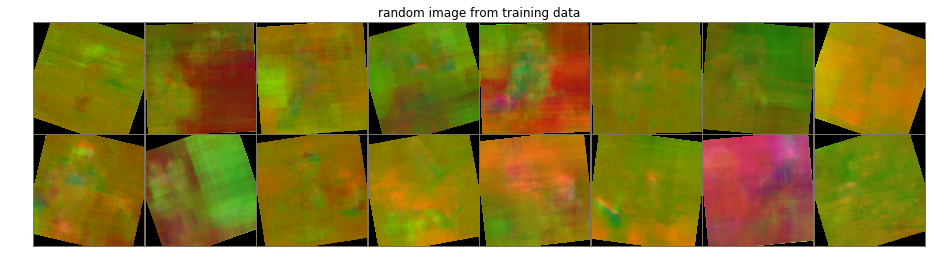

In [24]:
inputs,targets =  next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16, 12))
imshow(out, title='random image from training data')

In [25]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

# load pre-trained ResNet50
model = load_pretrained_resnet50(model_path=None, num_classes=7)
model.apply(freeze_bn)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.00002)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

model = model.to(device)
criterion = criterion.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [26]:
# training
model, trn_loss_hist, val_loss_hist, trn_acc_hist, val_acc_hist = train_model(model, train_dl, valid_dl, criterion, optimizer, scheduler, num_epochs=20)

Epoch 1/20
----------
  train Loss: 1.98610 Acc: 0.11655
  valid Loss: 1.92170 Acc: 0.23232

Epoch 2/20
----------
  train Loss: 1.94599 Acc: 0.17249
  valid Loss: 1.89778 Acc: 0.18182

Epoch 3/20
----------
  train Loss: 1.92937 Acc: 0.18182
  valid Loss: 1.89468 Acc: 0.23232

Epoch 4/20
----------
  train Loss: 1.92167 Acc: 0.22611
  valid Loss: 1.89714 Acc: 0.23232

Epoch 5/20
----------
  train Loss: 1.91713 Acc: 0.20979
  valid Loss: 1.88089 Acc: 0.24242

Epoch 6/20
----------
  train Loss: 1.91499 Acc: 0.18648
  valid Loss: 1.86566 Acc: 0.25253

Epoch 7/20
----------
  train Loss: 1.89240 Acc: 0.23776
  valid Loss: 1.84589 Acc: 0.32323

Epoch 8/20
----------
  train Loss: 1.90468 Acc: 0.26807
  valid Loss: 1.84233 Acc: 0.33333

Epoch 9/20
----------
  train Loss: 1.88455 Acc: 0.22844
  valid Loss: 1.87022 Acc: 0.32323

Epoch 10/20
----------
  train Loss: 1.88560 Acc: 0.24709
  valid Loss: 1.83651 Acc: 0.31313

Epoch 11/20
----------
  train Loss: 1.86571 Acc: 0.26807
  valid Los

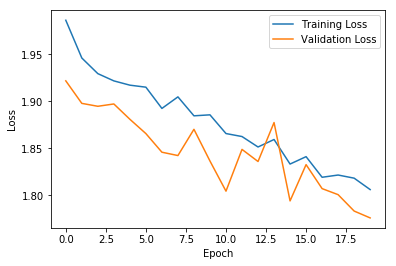

In [27]:
loss_acc = 'Loss'
plot_loss(trn_loss_hist, val_loss_hist, loss_acc)

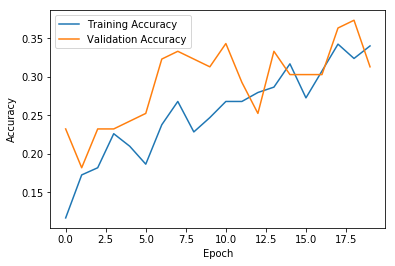

In [28]:
loss_acc = 'Accuracy'
plot_loss(trn_acc_hist, val_acc_hist, loss_acc)

In [51]:
for param in model.parameters():
    param.require_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0002, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.9)
model = model.to(device)
criterion = criterion.to(device)

In [52]:
model, trn_loss_hist1, val_loss_hist1, trn_acc_hist1, val_acc_hist1 = train_model(model, train_dl, valid_dl, criterion, optimizer, scheduler, num_epochs=15)

Epoch 1/15
----------
  train Loss: 0.92046 Acc: 0.70396
  valid Loss: 1.62268 Acc: 0.40404

Epoch 2/15
----------
  train Loss: 0.87689 Acc: 0.72960
  valid Loss: 1.53716 Acc: 0.41414

Epoch 3/15
----------
  train Loss: 0.85455 Acc: 0.72960
  valid Loss: 1.53018 Acc: 0.35354

Epoch 4/15
----------
  train Loss: 0.79916 Acc: 0.76457
  valid Loss: 1.59079 Acc: 0.37374

Epoch 5/15
----------
  train Loss: 0.77261 Acc: 0.78788
  valid Loss: 1.65198 Acc: 0.34343

Epoch 6/15
----------
  train Loss: 0.76164 Acc: 0.78089
  valid Loss: 1.60092 Acc: 0.41414

Epoch 7/15
----------
  train Loss: 0.73542 Acc: 0.79487
  valid Loss: 1.79735 Acc: 0.36364

Epoch 8/15
----------
  train Loss: 0.69719 Acc: 0.79953
  valid Loss: 1.59748 Acc: 0.37374

Epoch 9/15
----------
  train Loss: 0.65737 Acc: 0.81585
  valid Loss: 1.59969 Acc: 0.39394

Epoch 10/15
----------
  train Loss: 0.62279 Acc: 0.82517
  valid Loss: 1.57145 Acc: 0.37374

Epoch 11/15
----------
  train Loss: 0.65315 Acc: 0.80653
  valid Los

In [53]:
trn_loss_hist.extend(trn_loss_hist1)
val_loss_hist.extend(val_loss_hist1)
trn_acc_hist.extend(trn_acc_hist1)
val_acc_hist.extend(val_acc_hist1)

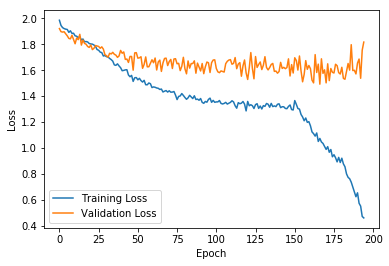

In [54]:
loss_acc = 'Loss'
plot_loss(trn_loss_hist, val_loss_hist, loss_acc)

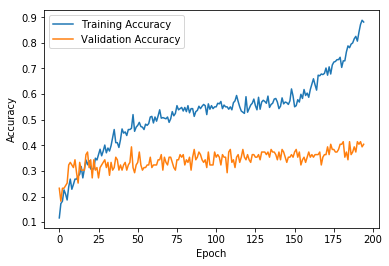

In [55]:
loss_acc = 'Accuracy'
plot_loss(trn_acc_hist, val_acc_hist, loss_acc)

In [56]:
# acuracy on validation data

def evaluate_model(model, dataloader):
    model.eval()  # for batch normalization layers
    corrects = 0
    for inputs, targets in dataloader:
        inputs, targets = to_var(inputs, True), to_var(targets, True)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        corrects += (preds == targets.data).sum()
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

In [57]:
# mAP
m = torch.nn.Softmax(dim=1)
def calculate_model_mAP(model, dataloader):
    mAP = APMeter()
    model.eval()  # for batch normalization layers
    corrects = 0
    for inputs, targets in dataloader:
        inputs, targets = to_var(inputs, True), to_var(targets, True)
        outputs = model(inputs)
        outputs = m(outputs)
        targets.resize_(targets.size(0), 1)
        targets = Variable(targets)
        
        one_hot = torch.cuda.FloatTensor(targets.size(0), outputs.size(1)).zero_()
        one_hot.scatter_(1, targets.data, 1)
        one_hot = Variable(one_hot)
        mAP.add(outputs,one_hot)

        #print(outputs.data)
    
    for i, value in enumerate(mAP.value()):
        print(train_ds.classes[i], ' AP: {:.2f}'.format(100. * value))
    print('mAP: {:.2f}'.format(100. * mAP.value().sum() / mAP.value().size(0)))

In [36]:
evaluate_model(model, valid_dl)

accuracy: 35.00


In [ ]:
evaluate_model(model, train_dl)

In [ ]:
visualize_model(model, train_dl)

In [ ]:
visualize_model(model, valid_dl)

In [ ]:
plot_errors(model, train_dl)

In [ ]:
# confusion matrix
y_pred, y_true = predict_class(model, valid_dl)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(12,12 ))

In [ ]:
# Look at the sizes of the images

fnames = glob.glob(f'{trn_dir}/*/*.png')
sizes = [Image.open(f).size for f in fnames]

hs, ws = list(zip(*sizes))

plt.figure(figsize=(12., 4.))
plt.hist(hs)
plt.hist(ws);

In [ ]:
visualize_model(model, valid_dl, num_images=6)

In [ ]:
plot_errors(model, valid_dl)

In [67]:
### testing

class_names = train_ds.classes
test_dir = f'{DATA_DIR}\\test'
test_ds = datasets.ImageFolder(test_dir,valid_transforms)
len(test_ds)

399

In [69]:
### dataloder

test_dl =  torch.utils.data.DataLoader(test_ds,batch_size= batch_size, num_workers=4)

In [70]:
pred_class_names, y = predict_class_names(model, test_dl, class_names)

test_fnames= glob.glob(f'{test_dir}/*/*.png')
len(test_fnames), test_fnames [:5]





  0%|                                                                                           | 0/25 [00:00<?, ?it/s]



  4%|███▎                                                                               | 1/25 [00:01<00:43,  1.83s/it]



 12%|█████████▉                                                                         | 3/25 [00:01<00:28,  1.30s/it]



 20%|████████████████▌                                                                  | 5/25 [00:02<00:18,  1.07it/s]



 28%|███████████████████████▏                                                           | 7/25 [00:02<00:12,  1.48it/s]



 36%|█████████████████████████████▉                                                     | 9/25 [00:02<00:07,  2.02it/s]



 44%|████████████████████████████████████                                              | 11/25 [00:02<00:05,  2.72it/s]



 52%|██████████████████████████████████████████▋                                       | 13/25 [00:02<00:03,  3.60it/s]



 60%|███████

(399,
 ['F:/MyArticel/DTASET/NEW DATASETTT/willow_orgin_20_from_test/im2flow\\test\\InteractingWithComputer\\action0001.png',
  'F:/MyArticel/DTASET/NEW DATASETTT/willow_orgin_20_from_test/im2flow\\test\\InteractingWithComputer\\action0008.png',
  'F:/MyArticel/DTASET/NEW DATASETTT/willow_orgin_20_from_test/im2flow\\test\\InteractingWithComputer\\action0009.png',
  'F:/MyArticel/DTASET/NEW DATASETTT/willow_orgin_20_from_test/im2flow\\test\\InteractingWithComputer\\action0012.png',
  'F:/MyArticel/DTASET/NEW DATASETTT/willow_orgin_20_from_test/im2flow\\test\\InteractingWithComputer\\action0013.png'])

In [ ]:
test_fnames_len= len(test_fnames)
for i in range(test_fnames_len):
    test_fnames[i] = os.path.basename(test_fnames[i])
    
    len(test_fnames), test_fnames[:5]

In [ ]:
pred_result = np.stack([test_fnames, pred_class_names], axis=1)
len(pred_result), pred_result

In [71]:
evaluate_model(model, test_dl)

accuracy: 38.00


In [58]:
calculate_model_mAP(model, test_dl)

InteractingWithComputer  AP: 32.58
Photographing  AP: 24.35
PlayingMusic  AP: 49.83
RidingBike  AP: 64.07
RidingHorse  AP: 30.61
Running  AP: 27.87
Walking  AP: 32.48
mAP: 37.40


In [ ]:
plot_errors(model, test_dl)

In [ ]:
# confusion matrix
y_pred, y_true = predict_class(model, test_dl)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(12,12 ))